In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
from copy import deepcopy
import re


import numpy as np
import scipy as sc
import pandas as pd
import torch
print(torch.cuda.is_available())

import models
import utils
import dre
import rna
import vae
import designers
import editdistance

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib_venn import venn2, venn2_circles
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

True


2024-10-02 19:01:58.598992: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 19:01:58.599042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 19:01:58.600538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 19:01:58.608557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 19:02:00.384814: W tensorflow/comp

# check sampling and labeling progress

In [173]:
# sampled and labeled in rna-092324.ipynb
design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-092324-cbas-2.pkl'
with open(design_pkl_fname, 'rb') as f:
    name2designdata = pickle.load(f)

In [174]:
for name, thing in name2designdata.items():
    print(name, np.mean(thing[1]) if thing[1] is not None else None)

cbas-ff-0.1 0.2909068332030152
cbas-ff-0.2 0.28932085294412185
cbas-ff-0.3 0.289191860685151
cbas-ff-0.4 0.290421930068214
cbas-ff-0.5 0.2893225249311269
cbas-ff-0.6 0.29059342396873
cbas-ff-0.7 0.2918148759754926
cbas-ff-0.8 0.2904809028044726
cbas-ff-0.9 0.2919875703703996
cbas-cnn-0.1 0.2915568474438351
cbas-cnn-0.2 0.2902361660204455
cbas-cnn-0.3 0.29085737998759964
cbas-cnn-0.4 0.2913464339475652
cbas-cnn-0.5 0.2935177711329385
cbas-cnn-0.6 0.2906208235249779
cbas-cnn-0.7 0.2914742845514614
cbas-cnn-0.8 0.29203288580121617
cbas-cnn-0.9 0.29156276333217324
vae 0.28672066713046307


# plot

In [2]:
# load design names to test (copy from rna-selection-092424.ipynb)

# ----- build menu of design algorithm names -----
adalead_thresholds = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

design_names = ['vae']
for q in cbas_dbas_quantiles:
    q = round(q, 2)
    design_names.append(f'cbas-ridge-{q}t19')
    
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    design_names.append(f'dbas-ridge-{q}t19')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    design_names.append(f'pex-{model_name}') 
        
    if model_name != 'ridge':
        # cbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'cbas-{model_name}-{q}')
        
        # dbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'dbas-{model_name}-{q}')

In [120]:
# making pp_name2truemeans for 05.05 pp selection results
design_pkl_fname = '/data/wongfanc/rna-results/designs-041124-copy.pkl'
train_fname = '/data/wongfanc/rna-models/traindata-nsd0.02-040324.npz'
name2designdata = rna.prepare_name2designdata(
    design_pkl_fname,
    train_fname,
    verbose=False
)

No design data for dbas-ridge-0.3t0, exiting.
No design data for dbas-ridge-0.4t0, exiting.
No design data for dbas-ridge-0.5t0, exiting.
No design data for dbas-ridge-0.6t0, exiting.
No design data for dbas-ridge-0.7t0, exiting.
No design data for dbas-ridge-0.8t0, exiting.
No design data for dbas-ridge-0.9t0, exiting.


In [121]:
pp_name2truemeans = {}
for design_name in design_names:
    (_, ydesign_n, preddesign_n) = name2designdata[design_name]
    pp_name2truemeans[design_name] = np.mean(ydesign_n)

In [123]:
# pp_results_pkl_fname = 
# with open(pp_results_pkl_fname, 'wb') as f:
#     pickle.dump(pp_name2truemeans, f)

In [3]:
# load PP selection results, computed in nb
reload(utils)

pp_target_values = np.arange(0.25, 0.501, 0.004)
n_pp_trial = 200
pp_results_csv_fname = '/data/wongfanc/rna-results/selection-v0-050524.csv'
with open('/data/wongfanc/rna-results/selection-050524-truemeans.pkl', 'rb') as f:
    pp_name2truemeans = pickle.load(f)

pp_df = pd.read_csv(pp_results_csv_fname, index_col=0)
ppworst_v, pperr_v, ppdisc_v, ppval2configs = utils.process_rna_selection_experiments(
    pp_df, pp_target_values, design_names, pp_name2truemeans, n_pp_trial, imp_or_pp='pp', alpha=0.1
)

AssertionError: 

In [5]:
# load imputation selection results, computed in rna-selection-092424.ipynb
reload(utils)

imp_target_values = np.arange(0.25, 0.501, 0.004)
n_imp_trial = 3
imp_results_csv_fname = '/data/wongfanc/rna-results/selection-imputation-100224.csv'
imp_truemeans_pkl_fname = '/data/wongfanc/rna-results/selection-imputation-100224-truemeans.pkl'

imp_df = pd.read_csv(imp_results_csv_fname, index_col=0)
with open(imp_truemeans_pkl_fname, 'rb') as f:
    imp_name2truemeans = pickle.load(f)
    
impworst_v, imperr_v, impdisc_v, impval2configs = utils.process_rna_selection_experiments(
    imp_df, imp_target_values, design_names, imp_name2truemeans, n_imp_trial, imp_or_pp='imp', alpha=0.1
)

Processing imp results with the following 96 configurations, 63 target values in [0.25, 0.50], 3 trials, and alpha = 0.1:
  vae
  cbas-ridge-0.1t19
  cbas-ridge-0.2t19
  cbas-ridge-0.3t19
  cbas-ridge-0.4t19
  cbas-ridge-0.5t19
  cbas-ridge-0.6t19
  cbas-ridge-0.7t19
  cbas-ridge-0.8t19
  cbas-ridge-0.9t19
  dbas-ridge-0.1t19
  dbas-ridge-0.2t19
  adalead-ridge-0.5
  adalead-ridge-0.45
  adalead-ridge-0.4
  adalead-ridge-0.35
  adalead-ridge-0.3
  adalead-ridge-0.25
  adalead-ridge-0.2
  adalead-ridge-0.15
  adalead-ridge-0.1
  adalead-ridge-0.05
  adalead-ridge-0.01
  biswas-ridge-0.02
  biswas-ridge-0.015
  biswas-ridge-0.01
  biswas-ridge-0.005
  pex-ridge
  adalead-ff-0.5
  adalead-ff-0.45
  adalead-ff-0.4
  adalead-ff-0.35
  adalead-ff-0.3
  adalead-ff-0.25
  adalead-ff-0.2
  adalead-ff-0.15
  adalead-ff-0.1
  adalead-ff-0.05
  adalead-ff-0.01
  biswas-ff-0.02
  biswas-ff-0.015
  biswas-ff-0.01
  biswas-ff-0.005
  pex-ff
  cbas-ff-0.1
  cbas-ff-0.2
  cbas-ff-0.3
  cbas-ff-0.4
  cb

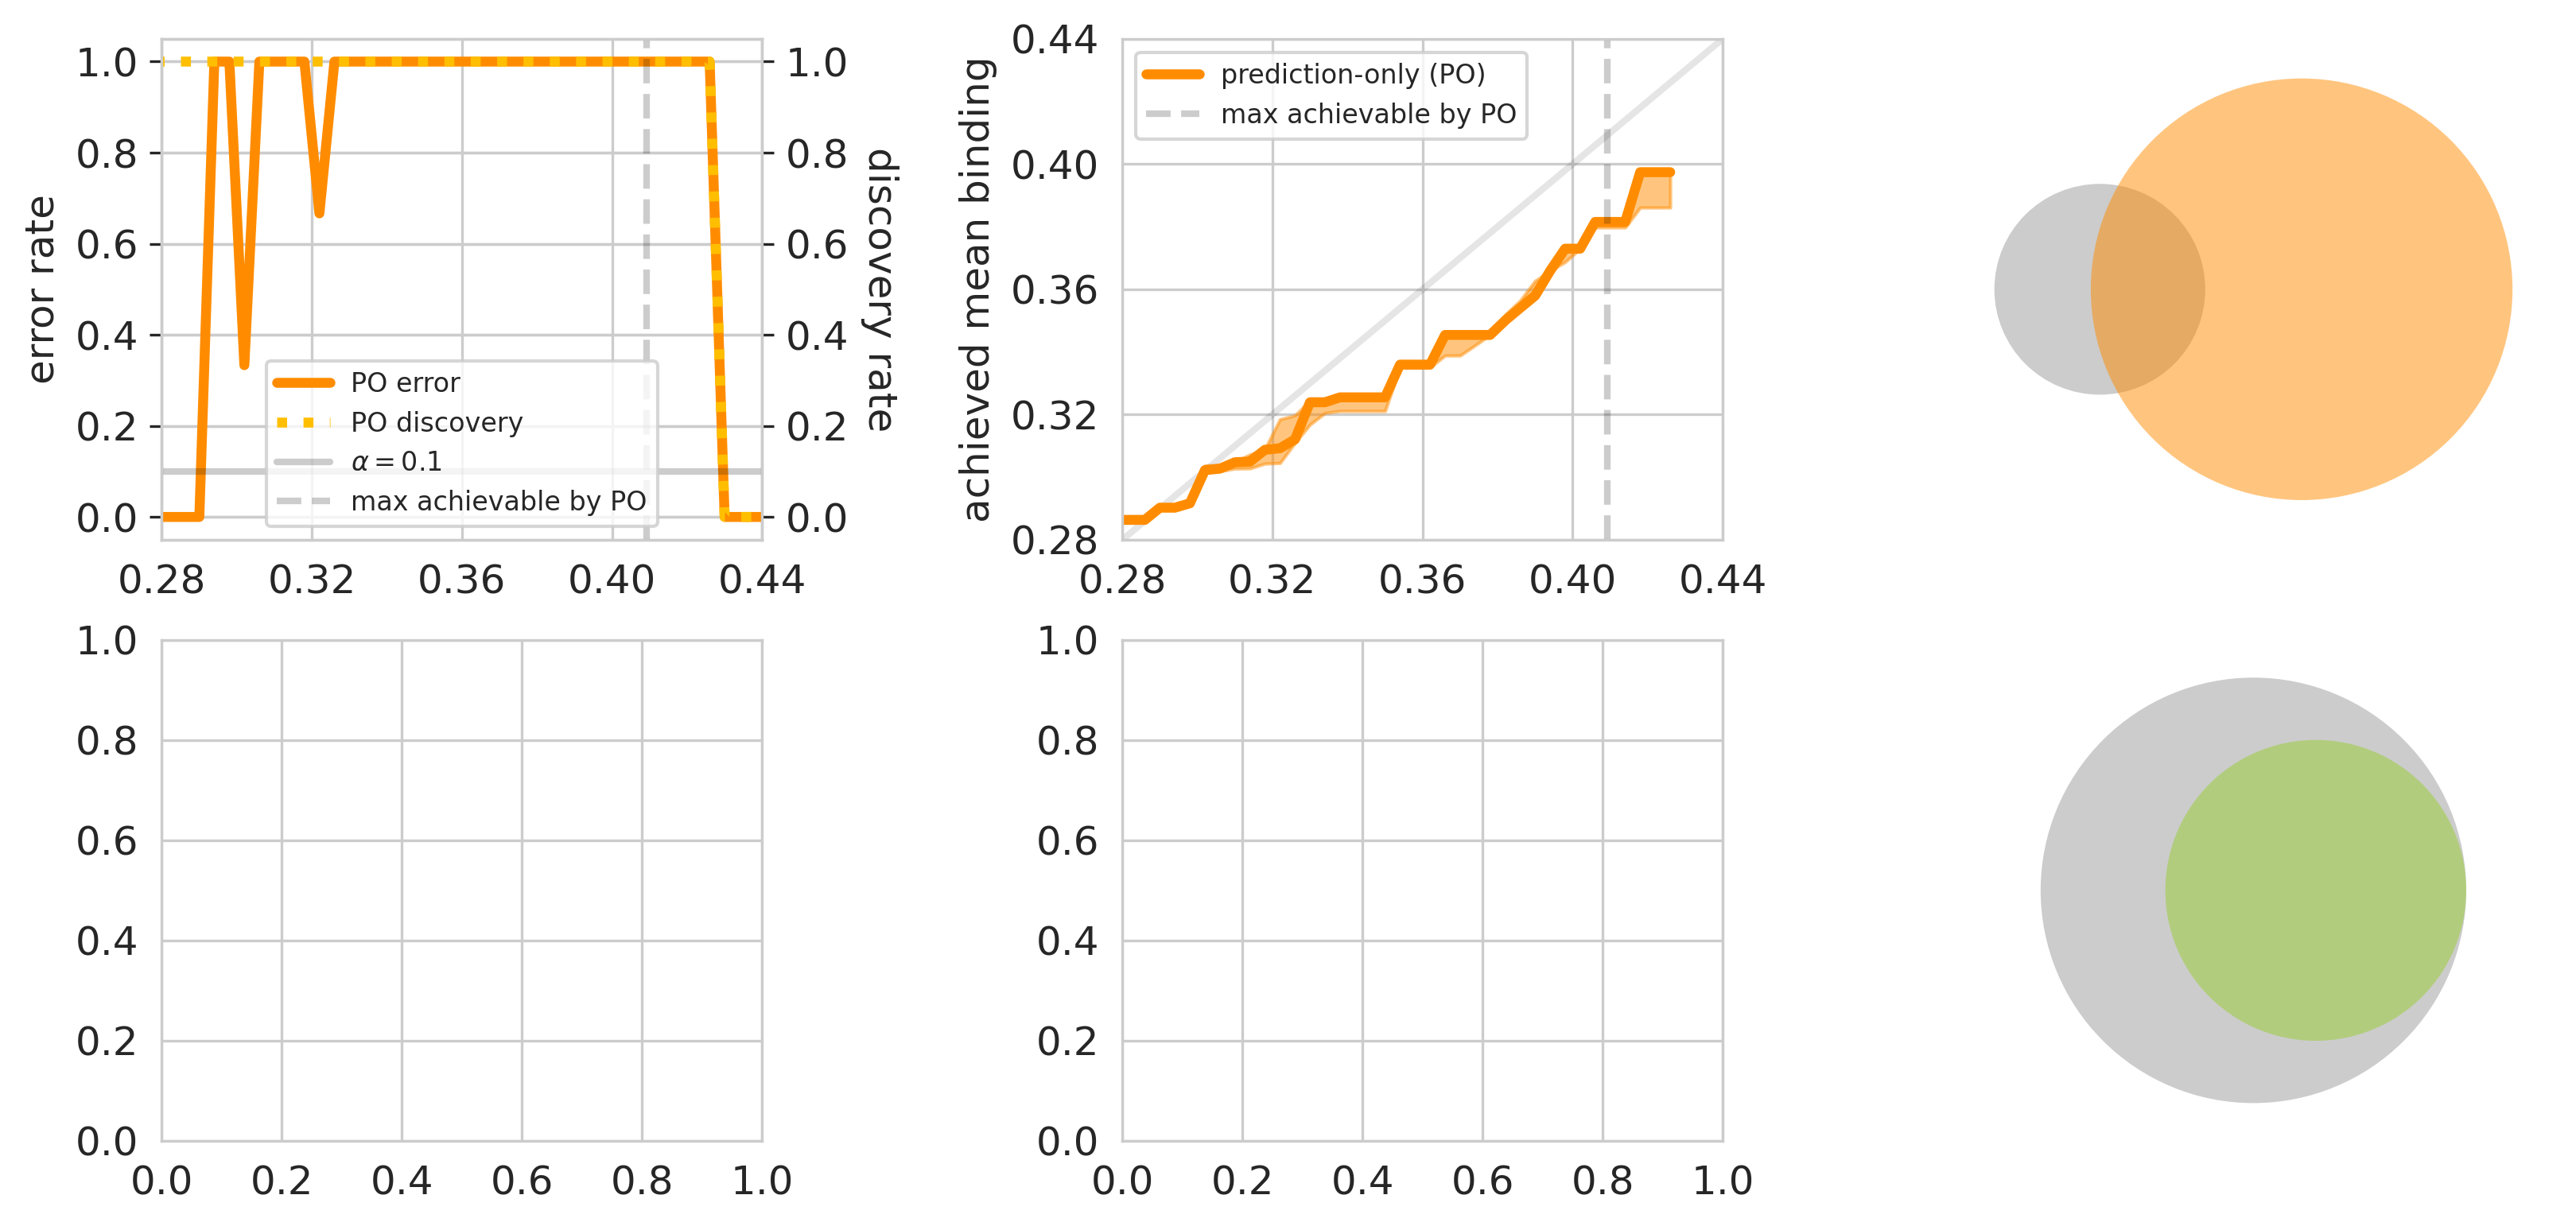

In [6]:
# plot two-row figure
fig = plt.figure(figsize=(13, 6), dpi=300)
outer = gridspec.GridSpec(1, 2, width_ratios = [2.5, 1], wspace=0.2)
gsleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = outer[0], wspace=0.6)
gsright = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[1])
ax00 = fig.add_subplot(gsleft[0, 0])
ax10 = fig.add_subplot(gsleft[1, 0])
ax01 = fig.add_subplot(gsleft[0, 1])
ax11 = fig.add_subplot(gsleft[1, 1])
ax02 = fig.add_subplot(gsright[0, 0])
ax12 = fig.add_subplot(gsright[1, 0])

alpha = 0.1
imp_color = 'darkorange'
pp_color = 'yellowgreen'

imp_max_achievable = np.max([np.mean(means_t) for means_t in imp_name2truemeans.values()])
pp_max_achievable = np.max(list(pp_name2truemeans.values()))
imp_xlim = [0.28, 0.44]
imp_xticks = np.arange(0.28, 0.45, 0.04)
pp_xlim = [0.28, 0.44]
pp_xticks = np.arange(0.28, 0.45, 0.04)

# ===== subplots (a, d) =====

ax00.set_ylabel('error rate');
ax00.set_ylim([-0.05, 1.05])
ax00.set_yticks(np.arange(0, 1.1, 0.2))

disc_ax = ax00.twinx()
disc_ax.plot(imp_target_values, imperr_v, c=imp_color, linewidth=3, label='PO error');
disc_ax.plot(imp_target_values, impdisc_v, ':', c=(255/255, 191/255, 0), linewidth=3, label='PO discovery');
disc_ax.axhline(alpha, linestyle='-', color='k', alpha=0.2, linewidth=2, label=r'$\alpha = {}$'.format(alpha));
disc_ax.axvline(imp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max achievable by PO')
disc_ax.legend(fontsize=8)
disc_ax.set_ylabel('discovery rate', rotation=270, labelpad=15);
disc_ax.set_yticks(np.arange(0, 1.05, 0.2))
disc_ax.set_xticks(imp_xticks)
disc_ax.set_xlim(imp_xlim)

# ax10.set_ylabel('error rate');
# ax10.set_xlabel('target mean binding');
# ax10.set_ylim([-0.05, 1.05])
# ax10.set_yticks(np.arange(0, 1.05, 0.2))

# disc_ax = ax10.twinx()
# disc_ax.plot(pp_target_values, pperr_v, c=pp_color, linewidth=3, label='PP error (ours)');
# disc_ax.plot(pp_target_values, ppdisc_v, ':', c=pp_color, linewidth=3, label='PP discovery (ours)');
# disc_ax.axhline(alpha, linestyle='-', color='k', alpha=0.2, linewidth=2, label=r'$\alpha = {}$'.format(alpha));
# disc_ax.axvline(pp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max achievable by PP')
# disc_ax.legend(fontsize=8)
# disc_ax.set_ylabel('discovery rate', rotation=270, labelpad=15);
# disc_ax.set_yticks(np.arange(0, 1.05, 0.2))
# disc_ax.set_xticks(pp_xticks)
# disc_ax.set_xlim(pp_xlim)


# ===== subplots (b, e) =====

q_low = 0.2
q_high = 0.8

ax01.plot(
    [np.min(imp_target_values) - 0.02, np.max(imp_target_values) + 0.02],
    [np.min(imp_target_values) - 0.02, np.max(imp_target_values) + 0.02],
    '-k', alpha=0.1, linewidth=2
);
ax01.plot(
    imp_target_values, [np.median(worst) if len(worst) else np.nan for worst in impworst_v],
    c=imp_color, label='prediction-only (PO)', linewidth=3,
)
ax01.fill_between(
    imp_target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
)
ax01.axvline(imp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max achievable by PO')
ax01.legend(fontsize=8)
ax01.set_ylabel('achieved mean binding');
ax01.set_xlim(imp_xlim)
ax01.set_ylim(imp_xlim)
ax01.set_xticks(imp_xticks)
ax01.set_yticks(imp_xticks)

# ax11.plot([np.min(pp_target_values) - 0.02, np.max(pp_target_values) + 0.02],
#           [np.min(pp_target_values) - 0.02, np.max(pp_target_values) + 0.02],
#           '-k', alpha=0.1, linewidth=2)
# ax11.plot(
#     pp_target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
#     c=pp_color, label='prediction-powered (PP, ours)', linewidth=3,
# )
# ax11.fill_between(
#     pp_target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
#     [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
#     color=pp_color, alpha=0.5,
# )
# ax11.axvline(pp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max achievable by PP')
# ax11.legend(fontsize=8)
# ax11.set_xlabel('target mean binding');
# ax11.set_ylabel('achieved mean binding');
# ax11.set_xlim(pp_xlim)
# ax11.set_ylim(pp_xlim)
# ax11.set_xticks(pp_xticks)
# ax11.set_yticks(pp_xticks)



# ===== subplots (c, f) =====

v = venn2_circles(subsets = (1, 7, 1), ax=ax02);
v[0].set_color('black')
v[0].set_alpha(0.2)
v[0].set_lw(0)
v[1].set_color(imp_color)
v[1].set_alpha(0.5)
v[1].set_lw(0)

v = venn2_circles(subsets = (1, 0, 1), ax=ax12);
v[0].set_color('black')
v[0].set_alpha(0.2)
v[0].set_lw(0)
v[1].set_color(pp_color)
v[1].set_alpha(0.5)
v[1].set_lw(0)

# plt.savefig('../figures/gb1-.png')


# find examples for venn diagrams

In [166]:
# construct mapping from target value to imputation configurations that achieve it
imp_val2trueconfigs = {round(val, 4): [] for val in imp_target_values}
for name, means_t in imp_name2truemeans.items():
    for val in imp_target_values:
        val = round(val, 4)
        if np.mean(means_t) >= val:
            if name not in imp_val2trueconfigs[val]:
                imp_val2trueconfigs[val].append(name)
            

In [167]:
# find trials where not all achieving configurations are selected,
# for imputation venn diagram
for val in imp_target_values:
    val = round(val, 4)
    if val > 0.4:
        trueconfigs = set(imp_val2trueconfigs[val])
        for name in trueconfigs:
            for t in range(2):
                selectedconfigs = set(impval2configs[val][t])
                if name not in selectedconfigs:
                    print(val,
                          len(trueconfigs.difference(selectedconfigs)),
                          len(selectedconfigs.difference(trueconfigs)),
                          len(trueconfigs.intersection(selectedconfigs)))
                    print(trueconfigs.difference(selectedconfigs))
                    print(selectedconfigs.difference(trueconfigs))
                    print(trueconfigs.intersection(selectedconfigs))

0.406 1 6 0
{'adalead-cnn-0.01'}
{'cbas-ridge-0.9t19', 'adalead-ridge-0.1', 'adalead-ff-0.05', 'adalead-ridge-0.05', 'adalead-ridge-0.01', 'adalead-ff-0.01'}
set()
0.406 1 6 0
{'adalead-cnn-0.01'}
{'cbas-ridge-0.9t19', 'adalead-ridge-0.1', 'adalead-ff-0.05', 'adalead-ridge-0.05', 'adalead-ridge-0.01', 'adalead-ff-0.01'}
set()


In [147]:
# construct mapping from target value to PP configurations that achieve it
pp_val2trueconfigs = {round(val, 4): [] for val in pp_target_values}
for name, mean in pp_name2truemeans.items():
    for val in pp_target_values:
        val = round(val, 4)
        if mean >= val:
            assert(name not in pp_val2trueconfigs[val])
            pp_val2trueconfigs[val].append(name)
            

In [165]:
# find trials where not all achieving configurations are selected,
# for PP venn diagram
trial_idx = 13
for val in pp_target_values:
    val = round(val, 4)
    if val > 0.4:
        trueconfigs = set(val2trueconfigs[val])
        selectedconfigs = set(ppval2configs[val][trial_idx])
        
        for name in trueconfigs:
            if name not in selectedconfigs:  # look for when didn't select some successful ones
                print(val,
                      len(trueconfigs.difference(selectedconfigs)),
                      len(selectedconfigs.difference(trueconfigs)),
                      len(trueconfigs.intersection(selectedconfigs)))
                print(trueconfigs.difference(selectedconfigs))
                print(selectedconfigs.difference(trueconfigs))
                print(trueconfigs.intersection(selectedconfigs))

0.402 1 0 1
{'adalead-cnn-0.01'}
set()
{'cbas-ridge-0.9t19'}
0.406 1 1 0
{'adalead-cnn-0.01'}
{'cbas-ridge-0.9t19'}
set()
